In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from abus_classification import datasets, features

## 3D fft signature function

Steps for 3D FFT of a Tumor Mask:
1. Input: 3D Mask:
    - The tumor is provided as a 3D binary mask (e.g., a NumPy array where voxel values are 1 for the tumor and 0 elsewhere).

2. Extract the Surface/Boundary Points:
    - Use a method like the Marching Cubes algorithm (`skimage.measure.marching_cubes`) to extract the surface mesh of the 3D shape as a set of vertices.

3. Represent Surface as a 3D Signal:
    - Treat the vertices of the extracted surface as a set of (x,y,z) points.
    - Optionally, resample or center these points to make the distribution uniform or centered at the origin.

4. Compute the 3D FFT:
    - Represent the surface points as a signal in the complex domain: z=x+iy+jzz=x+iy+jz (or directly use the 3D coordinates as independent arrays for the FFT).
    - Use `numpy.fft.fftn` for the 3D FFT.

In [2]:
def generate_3d_tumor(size=64, center=None, radius=20):
    """
    Generate a 3D binary mask of a spherical tumor.
    Args:
        size (int): The size of the 3D grid.
        center (tuple): The center of the sphere (defaults to the middle of the grid).
        radius (int): The radius of the sphere.
    Returns:
        np.ndarray: 3D binary mask of the tumor.
    """
    if center is None:
        center = (size // 2, size // 2, size // 2)
    x, y, z = np.ogrid[:size, :size, :size]
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    tumor_mask = (distance <= radius).astype(np.uint8)
    return tumor_mask

In [3]:
# Generate a sample 3D tumor, its a 64x64x64 grid containing a circle of radius 20
sample_shape = generate_3d_tumor()
print (sample_shape.shape)

(64, 64, 64)


In [4]:
fft_result = features.shape_descriptor.fft3d_signature(sample_shape)
print (fft_result.shape)

(64, 64, 64)


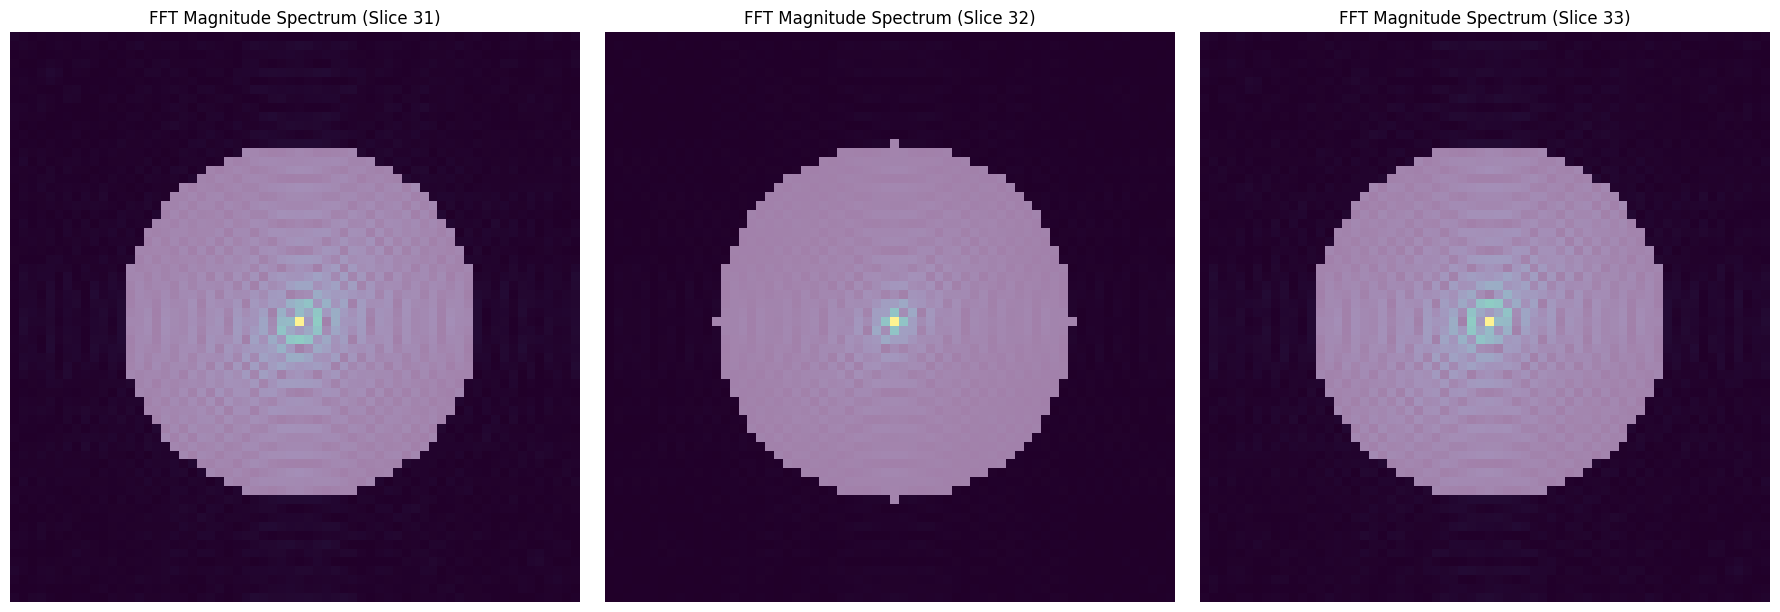

In [5]:
def visualize_results(mask, fft_result, slice_indices=None):
    """
    Visualize the tumor mask and its FFT magnitude spectrum.
    Args:
        mask (np.ndarray): 3D binary mask.
        fft_result (np.ndarray): Result of the 3D FFT.
        slice_indices (list): Indices of the slices to visualize (defaults to three central slices).
    """
    if slice_indices is None:
        mid_slice = mask.shape[0] // 2
        slice_indices = [mid_slice - 1, mid_slice, mid_slice + 1]  # Three middle slices

    fft_magnitude = np.abs(np.fft.fftshift(fft_result))

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(18, 6))

    for i, slice_idx in enumerate(slice_indices):
        # Original tumor (specific slice for visualization)
        axes[i].imshow(mask[:, :, slice_idx], cmap="gray")
        axes[i].set_title(f"Slice {slice_idx} of Tumor Mask")
        axes[i].axis("off")

        # FFT magnitude spectrum (specific slice of spectrum)
        axes[i].imshow(fft_magnitude[:, :, slice_idx], cmap="viridis", alpha=0.5)
        axes[i].set_title(f"FFT Magnitude Spectrum (Slice {slice_idx})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the modified function
visualize_results(sample_shape, fft_result)

## Running the method on the TDSC dataset

In [6]:
dataset = datasets.TDSCTumors(path="../data/tdsc")
print(len(dataset))

FileNotFoundError: [Errno 2] No such file or directory: '../data/tdsc/train/labels.csv'

In [7]:
from tqdm.notebook import tqdm

X = []
Y = []

for i, (_, mask, label) in tqdm(enumerate(dataset), total=len(dataset)):
    # Calculate the 3D FFT of the tumor mask
    fft_result = features.shape_descriptor.fft3d_signature(mask)
    # Store the FFT magnitude spectrum as a feature vector
    fft_magnitude = np.abs(np.fft.fftshift(fft_result))    
    # Flatten the FFT magnitude to create a feature vector
    X.append(fft_magnitude.flatten()[:200])
    Y.append(label)
    # np.save(f"./data/3d-fft-signature/x/{i}.npy", x)
    
X = np.array(X)
Y = np.array(Y)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
from sklearn.feature_selection import mutual_info_classif

# Calculate the mutual information between each feature and the labels
mi_scores = mutual_info_classif(X, Y)
# Get the indices of the features sorted by their mutual information score
feature_indices = np.argsort(mi_scores)[::-1]  # Sort in descending order
# Optionally, you can set a threshold to select top features
threshold = 0.025  # Example threshold
selected_indices = feature_indices[mi_scores[feature_indices] > threshold]

print(selected_indices)

[159 175 129  70 146 102 126 137  38  74  58 127   0  59 195  60 135 142
 112  52  39 154   5  50  45 183  78 145  97 139  15  76 104  19 125 132
  33 110 106  79  88 153  93  82  37  43  35 124 130 158 141 148  91  81
 123  95 169  96  90   1 143  73 192  86 133  10 163 161 171 191  71 122
 116  17  31 101  18 111 166 118  75  55 180 115 134  80 189  66  42  56
  85 149  44 194 173 196  92  62]


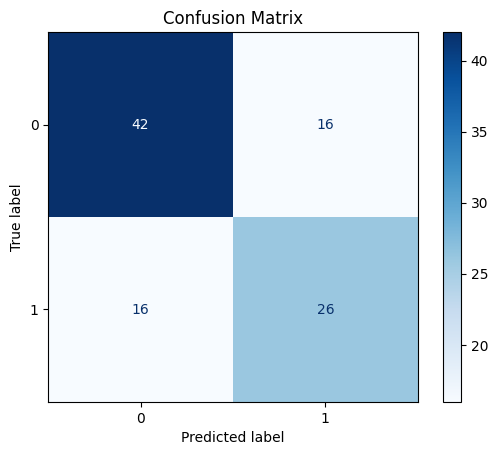

Accuracy: 0.68
AUC: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        58
           1       0.62      0.62      0.62        42

    accuracy                           0.68       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.68      0.68      0.68       100



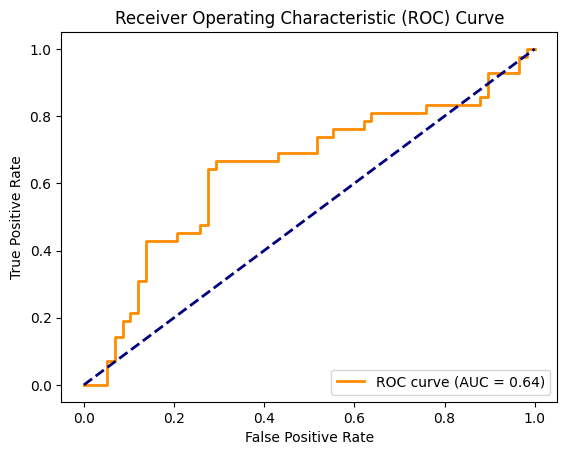

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np
import matplotlib.pyplot as plt


# Assuming X, Y, and selected_indices are already defined
X_selected = X[:, selected_indices]  # Select the features based on indices

# Initialize the SVM classifier
svm_classifier = SVC(probability=True)  # Enable probability estimates for ROC and AUC

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

# Lists to store true labels and predictions
predictions = []
probabilities = []  # Store probabilities for ROC and AUC
true_labels = []

# Initialize a scaler for standardization
scaler = StandardScaler()

# Perform LOOCV
for train_index, test_index in loo.split(X_selected):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Scale the features (fit on training data, transform both training and test data)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    svm_classifier.fit(X_train, Y_train)
    
    # Predict the left-out sample
    prediction = svm_classifier.predict(X_test)
    predictions.append(prediction[0])  # Store the prediction
    
    # Get probabilities for ROC and AUC
    probability = svm_classifier.predict_proba(X_test)[0]
    probabilities.append(probability[1])  # Store the probability for the positive class
    
    # Store the true label
    true_labels.append(Y_test[0])

# Convert to numpy arrays for compatibility with metrics
true_labels = np.array(true_labels)
probabilities = np.array(probabilities)
predictions = np.array(predictions)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Classification report (precision, recall, F1-score)
classification_metrics = classification_report(true_labels, predictions)

# Calculate additional metrics
precision = precision_score(true_labels, predictions, zero_division=0)
recall = recall_score(true_labels, predictions, zero_division=0)
f1 = f1_score(true_labels, predictions, zero_division=0)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")
print("Classification Report:")
print(classification_metrics)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


## Concatination with radiology features

In [10]:
def extract_radiology_features(volume, mask):

    whr = features.radiology.height_to_width_ratio(mask)
    h = features.radiology.entropy(volume*mask)
    ai = features.radiology.average_intensity(volume*mask)
    mc = features.radiology.margin_contrast(volume=volume, mask=mask)
    vi = features.radiology.variance_of_intensities(volume*mask)
    sh = features.radiology.sphericity(mask)
    cp = features.radiology.compactness(mask)
    # pab = features.radiology.posterior_acoustic_behavior(volume, mask)
    
    return np.array([whr, h,ai,mc,vi,sh,cp], dtype=np.float32)



In [11]:
X_radiology = []
for volume, mask, label in tqdm(dataset):
    X_radiology.append(extract_radiology_features(volume, mask))

X_radiology = np.array(X_radiology)

  0%|          | 0/100 [00:00<?, ?it/s]

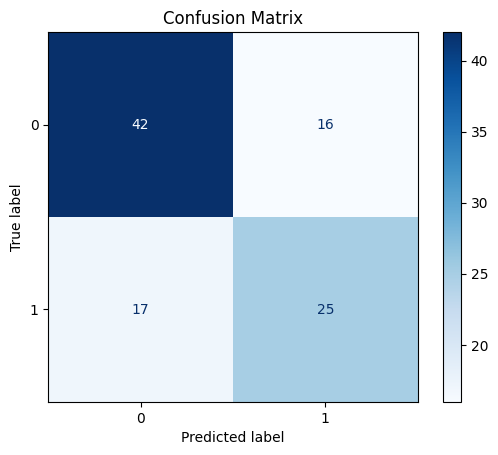

Accuracy: 0.67
AUC: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        58
           1       0.61      0.60      0.60        42

    accuracy                           0.67       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.67      0.67      0.67       100



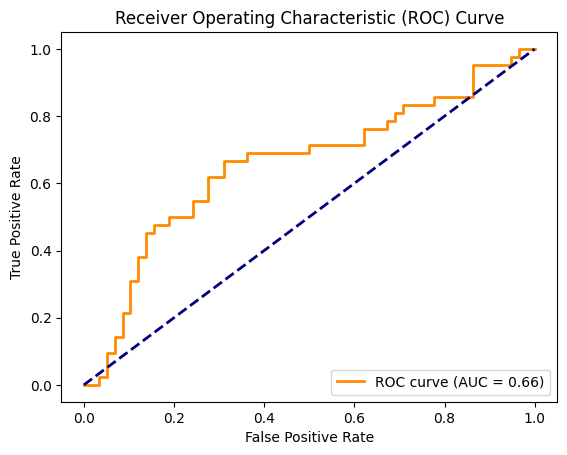

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np
import matplotlib.pyplot as plt


# Assuming X, Y, and selected_indices are already defined
X_selected = np.hstack((X[:, selected_indices], X_radiology))

# Initialize the SVM classifier
svm_classifier = SVC(probability=True)  # Enable probability estimates for ROC and AUC

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

# Lists to store true labels and predictions
predictions = []
probabilities = []  # Store probabilities for ROC and AUC
true_labels = []

# Initialize a scaler for standardization
scaler = StandardScaler()

# Perform LOOCV
for train_index, test_index in loo.split(X_selected):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Scale the features (fit on training data, transform both training and test data)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    svm_classifier.fit(X_train, Y_train)
    
    # Predict the left-out sample
    prediction = svm_classifier.predict(X_test)
    predictions.append(prediction[0])  # Store the prediction
    
    # Get probabilities for ROC and AUC
    probability = svm_classifier.predict_proba(X_test)[0]
    probabilities.append(probability[1])  # Store the probability for the positive class
    
    # Store the true label
    true_labels.append(Y_test[0])

# Convert to numpy arrays for compatibility with metrics
true_labels = np.array(true_labels)
probabilities = np.array(probabilities)
predictions = np.array(predictions)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Classification report (precision, recall, F1-score)
classification_metrics = classification_report(true_labels, predictions)

# Calculate additional metrics
precision = precision_score(true_labels, predictions, zero_division=0)
recall = recall_score(true_labels, predictions, zero_division=0)
f1 = f1_score(true_labels, predictions, zero_division=0)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")
print("Classification Report:")
print(classification_metrics)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
